## Preprocessing de features pour la seconde itération

#### Table Clients
- Pourcentage d'achat dans chaque catégorie (par ex 70% de vêtements pour femme, 30% divers)
- Découpage de l'âge en tranche
- Pourcentage d'achats d'articles déjà achetés une fois
- Durée moyenne entre chaque rachat d'un même article
- Groupe de code postal (voir `postal_code_groups.ipynb`)
- Clusterisation

#### Table Articles 
- Pourcentage d'achats par un client qui a déjà acheté l'article une fois (= rachat)
- Durée moyenne entre chaque rachat
- Pourcentage d'achat pour chaque tranche d'âge (ex 50% des achats de cet article sont faits par des 20-30 ans)

In [1]:
import pandas as pd
import numpy as np

In [5]:
# Chargement des tables
transactions = pd.read_pickle("pickles/transactions_clean.pkl")
customers = pd.read_pickle("pickles/customers_clean.pkl")
articles = pd.read_pickle("pickles/articles_clean.pkl")

### Pourcentage d'achat dans chaque catégorie / de rachats d'article

In [6]:
customer_purchases = transactions[['customer_id', 'article_id', 'week_number']].groupby(['customer_id', 'article_id'], as_index = False).agg(
    purchases = ('article_id', 'count'),
    first_purchase_day = ('week_number', 'min'),
    last_purchase_day = ('week_number', 'max'),
)

In [ ]:
article_to_merge = articles[['article_id', 'index_group_name']]
article_to_merge['index_group_name'] = article_to_merge['index_group_name'].str.lower()
index_dummies = pd.get_dummies(article_to_merge['index_group_name'], prefix='', prefix_sep='')

article_to_merge = pd.concat([article_to_merge, index_dummies], axis = 1)
article_to_merge.drop('index_group_name', 1, inplace=True)

In [8]:
customer_purchases = customer_purchases.merge(article_to_merge, how = 'left', on ='article_id')
customer_purchases['repurchases'] = customer_purchases['purchases'] - 1

customer_purchases['repurchase_interval'] = np.where(
    customer_purchases['repurchases'] != 0, 
    (customer_purchases['last_purchase_day'] - customer_purchases['first_purchase_day']) / customer_purchases['repurchases'], 
    0
)

In [12]:
# Mettre à jour les informations de catégorie pour tenir compte du nombre d'achat
customer_purchases['baby/children'] = customer_purchases['baby/children'] * customer_purchases['purchases']
customer_purchases['divided'] = customer_purchases['divided'] * customer_purchases['purchases']
customer_purchases['ladieswear'] = customer_purchases['ladieswear'] * customer_purchases['purchases']
customer_purchases['menswear'] = customer_purchases['menswear'] * customer_purchases['purchases']
customer_purchases['sport'] = customer_purchases['sport'] * customer_purchases['purchases']

In [60]:
# Sauvegarde intermédiaire.
customer_purchases.to_pickle('pickles/customer_purchases.pkl')

In [13]:
# Aggrégation par identifiant client.
customers_features = customer_purchases.groupby('customer_id', as_index = False).agg(
    baby = ('baby/children', 'sum')	,
    divided = ('divided', 'sum')	,
    ladieswear = ('ladieswear', 'sum')	,
    menswear = ('menswear', 'sum')	,
    sport = ('sport', 'sum'),
    total = ('purchases', 'sum'),
    repurchases = ('repurchases', 'sum'),
    repurchases_interval = ('repurchase_interval', 'sum')
)

In [ ]:
### Finalisation des nouvelles features

# Exprimer les ventes pour chaque catégorie en pourcentage du total
customers_features['baby'] = customers_features['baby'] / customers_features['total']
customers_features['divided'] = customers_features['divided'] / customers_features['total']
customers_features['ladieswear'] = customers_features['ladieswear'] / customers_features['total']
customers_features['menswear'] = customers_features['menswear'] / customers_features['total']
customers_features['sport'] = customers_features['sport'] / customers_features['total']

# Finaliser le calcul de l'intervalle moyen entre deux rachats
customers_features['repurchases_interval'] = np.where(
    customers_features['repurchases'] != 0, 
    customers_features['repurchases_interval'] / customers_features['repurchases'],
    0
)

# Suppression du total d'articles car on l'a déjà dans la table des Clients.
customers_features.drop('total', 1, inplace=True)

In [30]:
# Ajout des features à la table des clients.
customers = pd.read_pickle('pickles/customers_clean.pkl')
customers = customers.merge(customers_features, how = 'left', on = 'customer_id')

# Remplacement des valeurs nulles par 0
customers[['baby', 'divided', 'ladieswear', 'menswear',
       'sport', 'repurchases', 'repurchases_interval']] = customers[['baby', 'divided', 'ladieswear', 'menswear',
       'sport', 'repurchases', 'repurchases_interval']].fillna(0)

In [31]:
# Ajout des tranches d'âges
ages = [15, 25, 35, 45, 55, 65]

for age in ages:
    customers[f'age_around_{age}'] = 1 - np.abs(customers['age'] - age) / 10
    customers[f'age_around_{age}'].clip(0, 1, inplace = True)
    


In [32]:
# Ajout des groupes de code postaux
postal_code_groups = pd.read_pickle('pickles/postal_code_groups.pkl')
customers = customers.merge(postal_code_groups, on="postal_code", how = "left")
customers['postal_code_group'] = customers['postal_code_group'].fillna(0).astype('int16')

In [43]:
# Sauvegarde intermédiaire.
customers.to_pickle('pickles/customers_second_iteration.pkl')
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,average_cart_articles,average_cart_price,total_carts,...,sport,repurchases,repurchases_interval,age_around_15,age_around_25,age_around_35,age_around_45,age_around_55,age_around_65,postal_code_group
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,ACTIVE,None,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,1.900000,0.054393,10,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.6,0.4,0.0,4
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0,0,ACTIVE,None,25,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,3.250000,0.100510,24,...,0.012821,14.0,5.285714,0.0,1.0,0.0,0.0,0.0,0.0,4
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,ACTIVE,None,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,2.142857,0.086646,7,...,0.066667,1.0,0.000000,0.1,0.9,0.0,0.0,0.0,0.0,4
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,ACTIVE,None,54,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,2.000000,0.060983,1,...,1.000000,0.0,0.000000,0.0,0.0,0.0,0.1,0.9,0.0,1
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1,1,ACTIVE,Regularly,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,2.166667,0.078282,6,...,0.153846,1.0,2.000000,0.0,0.0,0.0,0.3,0.7,0.0,1


#### Clusterisation des Clients

In [48]:
# Préparation des données
customers = pd.read_pickle('pickles/customers_second_iteration.pkl')

features_list = ['FN', 'Active', 'average_cart_articles',
       'average_cart_price', 'total_carts', 'total_articles', 'total_price',
       'average_cart_interval', 'baby', 'divided', 'ladieswear', 'menswear',
       'sport', 'repurchases', 'repurchases_interval', 'age_around_15',
       'age_around_25', 'age_around_35', 'age_around_45', 'age_around_55',
       'age_around_65']

cluster_features = customers[features_list].fillna(0)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(cluster_features)

In [49]:
# Création de données de validation pour évaluer la clusterisation
last_week_sales = transactions[transactions['week_number'] == 0][['customer_id', 'article_id']]

validation_data = last_week_sales.groupby(['customer_id'], as_index = False).agg(
    purchased_articles = ('article_id', lambda x: list(x))
)

In [ ]:
# Initialisation des Clusters
from sklearn.cluster import KMeans
from utils.map12_from_series import map12_from_series

# Recherche du nombre de clusters qui donnera le meilleur score MAP@12
score_curve = [0.010221290725402028] # Répercussion du score obtenu dans `postal_code_groups.ipynb` pour la liste des ventes générale
best_score = 0

customers_group = customers[['customer_id']]
    
for k in range(2, 15):
    
    print(f"\r Entraînement pour {k} clusters                    ", end="")
    model = KMeans(n_clusters=k).fit(X)
    clusters = model.predict(X)
    
    # Process a top sales list for each groups.
    customers_group['group'] = clusters
    
    top_sales_by_group = last_week_sales.merge(customers_group, on ='customer_id', how='left').groupby(
        ['group', 'article_id'],
        as_index = False
    ).agg(
        sales = ('article_id', 'count')
    )
    
    print(f"\r Mise en forme des données                   ", end="")
    
    # Assign the lists to each postal code
    top_sales_lists = {}
    for group in range(0, k + 1):
        top_sales_lists[group] = top_sales_by_group.loc[top_sales_by_group['group'] == group].nlargest(12, columns = ['sales'])['article_id'].to_list()
    
    customers_group.loc[:, 'prediction'] = customers_group.loc[:, 'group'].apply(lambda x: top_sales_lists[x])
    
    # Put the prediction aside of the real lists.
    validation_data_with_prediction = validation_data.merge(customers_group, on = 'customer_id', how='left')
    
    print(f"\r Calcul du score pour {k} clusters                 ", end="")
    score = map12_from_series(validation_data_with_prediction['purchased_articles'], validation_data_with_prediction['prediction']).sum() / len(validation_data_with_prediction)
    
    print(f"Score pour {k} clusters: {score}")
    
    if score > best_score:
        best_model = model
        best_clusters = clusters
        
    score_curve.append(score)



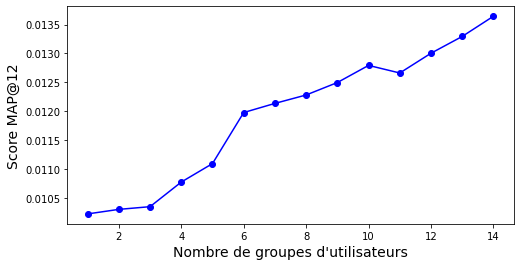

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(range(1, 15), score_curve, "bo-")
plt.xlabel("Nombre de groupes d'utilisateurs", fontsize=14)
plt.ylabel("Score MAP@12", fontsize=14)
plt.show()

In [53]:
# Partons sur 12 clusters.
model = KMeans(n_clusters=12).fit(X)
clusters = model.predict(X)

# Récupération et affichage des centroïdes.
centroids_values = scaler.inverse_transform(model.cluster_centers_)
centroids = pd.DataFrame(centroids_values, columns=features_list)
centroids

,FN,Active,average_cart_articles,average_cart_price,total_carts,total_articles,total_price,average_cart_interval,baby,divided,...,menswear,sport,repurchases,repurchases_interval,age_around_15,age_around_25,age_around_35,age_around_45,age_around_55,age_around_65
0,1.000000,9.935434e-01,2.923866,0.075670,8.535499,27.908497,0.672161,9.468693,0.015186,0.285447,...,0.056471,0.037617,1.300248,1.902800,2.492147e-01,6.903298e-01,5.877801e-02,-4.968248e-14,2.883804e-14,9.477136e-05
1,0.011038,4.496403e-14,3.277674,0.083729,6.645254,23.158736,0.538830,10.300549,0.013672,0.380487,...,0.052635,0.089129,0.952963,1.671080,2.385621e-01,6.806168e-01,6.980359e-02,-2.939315e-14,1.229572e-14,1.402477e-04
2,1.000000,9.918415e-01,3.626527,0.096558,8.664622,33.905668,0.847317,8.957464,0.085260,0.168545,...,0.050783,0.040447,1.794353,2.193627,1.064149e-14,2.194044e-01,6.989239e-01,8.167167e-02,-5.551115e-15,-1.693090e-15
3,0.021505,4.940492e-15,2.644057,0.082142,1.783294,5.465199,0.145022,3.532042,0.010461,0.029787,...,0.900810,0.013593,0.187408,0.340660,9.017139e-02,2.990907e-01,1.513909e-01,1.504925e-01,1.893054e-01,6.638643e-02
4,0.006457,4.612977e-14,2.814095,0.085389,5.866741,18.260696,0.493147,8.515616,0.013372,0.124807,...,0.036584,0.039720,0.875937,1.288093,6.157574e-15,4.052314e-14,1.967870e-14,1.065675e-01,5.689531e-01,2.202444e-01
5,1.000000,9.939731e-01,2.701577,0.079357,8.737924,25.623123,0.692891,9.089465,0.026884,0.158995,...,0.065916,0.031279,1.430757,1.694845,1.421363e-14,-9.603429e-15,1.787459e-14,9.830401e-02,5.636006e-01,2.614096e-01
6,0.006674,4.229950e-14,3.370830,0.094386,6.844482,24.861854,0.627071,9.514767,0.048705,0.187436,...,0.043543,0.056461,1.151556,1.797370,1.427608e-14,-8.271162e-15,9.545840e-02,7.379257e-01,1.666159e-01,-1.783296e-15
7,0.029423,1.343370e-14,4.008168,0.082975,1.573976,6.872689,0.130325,3.607297,0.907570,0.024409,...,0.013109,0.011591,0.158945,0.153223,1.044000e-02,9.145682e-02,3.496251e-01,3.591331e-01,1.000329e-01,3.419661e-02
8,1.000000,9.927500e-01,3.259963,0.086017,8.644632,30.349630,0.747004,8.971541,0.117788,0.223717,...,0.070571,0.040308,1.579718,2.048210,1.029177e-14,-2.736700e-14,9.646157e-02,7.281601e-01,1.713979e-01,1.447421e-04
9,0.011612,4.762857e-14,3.133168,0.086956,6.156069,22.124676,0.567255,8.294589,0.006407,0.086408,...,0.021338,0.023320,0.977470,1.492142,1.616687e-01,7.407738e-01,9.755758e-02,-5.220824e-14,3.094747e-14,-1.894318e-15


Sauvegarde finale

In [55]:
customers['group'] = clusters
customers.to_pickle('pickles/customers_second_iteration.pkl')
customers.head(5)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,average_cart_articles,average_cart_price,total_carts,...,repurchases,repurchases_interval,age_around_15,age_around_25,age_around_35,age_around_45,age_around_55,age_around_65,postal_code_group,group
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,ACTIVE,None,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,1.900000,0.054393,10,...,0.0,0.000000,0.0,0.0,0.0,0.6,0.4,0.0,4,6
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0,0,ACTIVE,None,25,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,3.250000,0.100510,24,...,14.0,5.285714,0.0,1.0,0.0,0.0,0.0,0.0,4,9
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,ACTIVE,None,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,2.142857,0.086646,7,...,1.0,0.000000,0.1,0.9,0.0,0.0,0.0,0.0,4,9
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,ACTIVE,None,54,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,2.000000,0.060983,1,...,0.0,0.000000,0.0,0.0,0.0,0.1,0.9,0.0,1,4
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1,1,ACTIVE,Regularly,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,2.166667,0.078282,6,...,1.0,2.000000,0.0,0.0,0.0,0.3,0.7,0.0,1,5


### Features de la table Articles

In [2]:
### Récupération des statistiques concernant les rachats.
customer_purchases = pd.read_pickle('pickles/customer_purchases.pkl')
article_purchases = customer_purchases[['customer_id','article_id','purchases','first_purchase_day','last_purchase_day', 'repurchases', 'repurchase_interval']]


In [4]:
# Ajout des informations concernant l'âge des clients.
customers_features = pd.read_pickle('pickles/customers_second_iteration.pkl')
customers_features = customers_features.drop(['FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code', 'average_cart_articles',
       'average_cart_price', 'total_carts', 'total_articles', 'total_price',
       'average_cart_interval', 'baby', 'divided', 'ladieswear', 'menswear',
       'sport', 'repurchases', 'repurchases_interval'], 1)

article_purchases = article_purchases.merge(customers_features, how = 'left', on = 'customer_id')

/tmp/ipykernel_20533/1864790770.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  customers_features = customers_features.drop(['FN', 'Active', 'club_member_status',


In [5]:
# Mise à jour du coefficient par âge en fonction des ventes
article_purchases['age_around_15'] = article_purchases['age_around_15'] * article_purchases['purchases']
article_purchases['age_around_25'] = article_purchases['age_around_25'] * article_purchases['purchases']
article_purchases['age_around_35'] = article_purchases['age_around_35'] * article_purchases['purchases']
article_purchases['age_around_45'] = article_purchases['age_around_45'] * article_purchases['purchases']
article_purchases['age_around_55'] = article_purchases['age_around_55'] * article_purchases['purchases']
article_purchases['age_around_65'] = article_purchases['age_around_65'] * article_purchases['purchases']

In [6]:
# Aggrégation par article
article_features = article_purchases.groupby('article_id', as_index = False).agg(
    age_around_15 = ('age_around_15', 'sum'),
    age_around_25 = ('age_around_25', 'sum'),
    age_around_35 = ('age_around_35', 'sum'),
    age_around_45 = ('age_around_45', 'sum'),
    age_around_55 = ('age_around_55', 'sum'),
    age_around_65 = ('age_around_65', 'sum'),
    repurchases = ('repurchases', 'sum'),
    repurchase_interval = ('repurchase_interval', 'sum'),
    total = ('purchases', 'sum')
)

In [7]:
# Finalisation des features
article_features['age_around_15'] = article_features['age_around_15'] / article_features['total']
article_features['age_around_25'] = article_features['age_around_25'] / article_features['total']
article_features['age_around_35'] = article_features['age_around_35'] / article_features['total']
article_features['age_around_45'] = article_features['age_around_45'] / article_features['total']
article_features['age_around_55'] = article_features['age_around_55'] / article_features['total']
article_features['age_around_65'] = article_features['age_around_65'] / article_features['total']
article_features['repurchases'] = article_features['repurchases'] / article_features['total']
article_features['repurchase_interval'] = article_features['repurchase_interval'] / article_features['total']

In [8]:
article_features.to_pickle('pickles/article_features.pkl')
article_features.head()

,article_id,age_around_15,age_around_25,age_around_35,age_around_45,age_around_55,age_around_65,repurchases,repurchase_interval,total
0,0108775015,0.048799,0.427950,0.237359,0.127591,0.123305,0.024154,0.086264,0.442579,7535
1,0108775044,0.046047,0.397741,0.220985,0.143082,0.144617,0.036216,0.067420,0.410519,5666
2,0108775051,0.048588,0.406215,0.275141,0.114689,0.112994,0.041808,0.050847,0.011299,177
3,0110065001,0.043075,0.305193,0.206110,0.235743,0.172301,0.031059,0.037678,0.332994,982
4,0110065002,0.048340,0.268880,0.185685,0.255602,0.195436,0.032573,0.045643,0.301867,482


In [ ]:
# Ajout des nouvelles features à la table des articles.
articles = pd.read_pickle('pickles/articles_clean.pkl')
article_features.drop('total', 1, inplace = True)
articles = articles.merge(article_features, on = 'article_id', how = 'left')

In [11]:
# Sauvegarde finale.
articles.to_pickle('pickles/articles_second_iteration.pkl')
articles.head(5)

,article_id,product_code,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,...,average_price,has_image,age_around_15,age_around_25,age_around_35,age_around_45,age_around_55,age_around_65,repurchases,repurchase_interval
0,0108775015,0108775,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,...,0.008109,True,0.048799,0.427950,0.237359,0.127591,0.123305,0.024154,0.086264,0.442579
1,0108775044,0108775,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,...,0.008093,True,0.046047,0.397741,0.220985,0.143082,0.144617,0.036216,0.067420,0.410519
2,0108775051,0108775,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,...,0.004982,True,0.048588,0.406215,0.275141,0.114689,0.112994,0.041808,0.050847,0.011299
3,0110065001,0110065,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,...,0.020055,True,0.043075,0.305193,0.206110,0.235743,0.172301,0.031059,0.037678,0.332994
4,0110065002,0110065,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,...,0.018087,True,0.048340,0.268880,0.185685,0.255602,0.195436,0.032573,0.045643,0.301867
